### Imports

This notebook employs standard data science and ML libraries (`numpy`, `pandas`, `scikit-learn`) and visualization libraries (`matplotlib` and `seaborn`).

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

import os

# plot formatting
plt.style.use('bmh')
plt.rcParams['font.size'] = 12

### Load Data

We'll load the raw csv file into a pandas dataframe for exploration. Based on the metadata, we know that the column 'Property Id' is unique for each row and so we set that as the index column. We'll start exploring some basic features about dataset by inspecting the first few rows, inspecting the shape of the dataset, and sifting through columns that are already set with a numerical data type. 

In [2]:
# Read in raw data file
data = pd.read_csv("../data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv", index_col="Property Id")

In [3]:
# Print first few lines
data.head()

,Order,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
Property Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13286,1,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
28400,2,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
4778226,3,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
4778267,4,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10

Next we'll print some basic information about the dataset: its shape, features, and summary statistics.

In [4]:
# Shape information 
print(f"Shape of dataset: {data.shape}")

# Numeric features
numeric_cols = data.select_dtypes(include=['number']).columns
print("\nNumeric Columns:",  numeric_cols)

# Numeric features
nonnumeric_cols = data.select_dtypes(exclude=['number']).columns
print("\nNon-numeric Columns:",  nonnumeric_cols)

Shape of dataset: (11746, 59)

Numeric Columns: Index(['Order', 'DOF Gross Floor Area', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Property GFA - Self-Reported (ft²)', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract'],
      dtype='object')

Non-numeric Columns: Index(['Property Name', 'Parent Property Id', 'Parent Property Name',
       'BBL - 10 digits', 'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Address 2', 'Postal Code', 'Street Number', 'Street Name', 'Borough',
       'Primary Property Type - Self Selected',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest 

Looking at the cell above, we see that there are many columns which hold numerical data, such as those in units of ft² and kBtu. Based on the `data.head()` information, we also know that missing data are indicated with cells that store the string `"Not Available."`. Let's start the data cleaning process by first changing all missing values to `nan`. Next we'll identify columns that store numerical data by checking if they contain a unit (energy, volume, mass, etc.) and convert them to `float` types. Then we can view summary stats for all numeric columns with `data.describe()`.

In [5]:
# replace all instances of 'Not Available' with nan
data = data.replace({'Not Available': np.nan})

# We'll also manually add the ENERGY STAR Score column

units = ['ft', 'kBtu', 'Number of', 'Percent', 'Hours', 'gal', 'Tons', 'kWh', 'ENERGY STAR Score']

for col in data.columns:
    # check if there are any units or any other indication that this column is numeric
    for token in units:
        if token in col:
            try:
                data[col] = data[col].astype(float)
            except:
                print(f"Couldn't convert column '{col}'.")

# summary stats on numeric columns
data.describe()


,Order,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,11583.000000,10281.000000,10959.000000,9783.000000,10281.000000,9.000000e+00,2.581000e+03,1.321000e+03,5.940000e+02,1.600000e+01,9.360000e+02,1.030400e+04,1.150200e+04,1.096000e+04,1.167200e+04,1.166300e+04,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,280.071484,309.747466,11.072643,1.901441,417.915709,3.395398e+06,3.186882e+06,5.294367e+06,2.429105e+06,1.193594e+06,2.868907e+08,5.048545e+07,5.965472e+06,1.768752e+06,4.553657e+03,2.477937e+03,2.076339e+03,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,8607.178877,9784.731207,127.733868,97.204587,10530.524339,2.213237e+06,5.497154e+06,5.881863e+06,4.442946e+06,3.558178e+06,3.124603e+09,3.914719e+09,3.154430e+07,9.389154e+06,2.041639e+05,1.954498e+05,5.931295e+04,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.085973e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.690797e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,61.800000,65.100000,3.800000,0.100000,103.500000,1.663594e+06,2.550378e+05,2.128213e+06,0.000000e+00,5.698020e+04,4.320254e+06,1.098251e+06,1.043673e+06,3.019975e+05,3.287000e+02,1.474500e+02,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,78.500000,82.500000,5.300000,0.500000,129.400000,4.328815e+06,1.380138e+06,4.312984e+06,0.000000e+00,2.070020e+05,9.931240e+06,4.103962e+06,1.855196e+06,5.416312e+05,5.002500e+02,2.726000e+02,1.718000e+02,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,97.600000,102.500000,9.200000,0.700000,167.200000,4.938947e+06,4.445808e+06,6.514520e+06,4.293825e+06,2.918332e+05,2.064497e+07,6.855070e+06,4.370302e+06,1.284677e+06,9.084250e+02,4.475000e+02,4.249000e+02,1.584140e+05,8.031875e+03,70.805000,162.750000,40.817623,-73.932443,9.000000,33.000000,531.500000
max,14993.000000,1.354011e+07,1.421712e

The definition for columns regarding 'metered areas' is a bit unclear, so we can inspect those columns by checking what unique values they store. Based on the results, a reasonable assumption is that metered areas refers to areas of the building for which energy and water usage data is measurable.

In [6]:
print("\nUnique values for 'Metered Areas (Water)':\n", data['Metered Areas  (Water)'].unique())

print("\nUnique values for 'Metered Areas (Energy)':\n", data['Metered Areas (Energy)'].unique())


Unique values for 'Metered Areas (Water)':
 [nan 'Whole Building' 'Combination of common and tenant areas'
 'Another configuration' 'Tenant areas only' 'Common areas only'
 'Tenant areas (all energy loads)']

Unique values for 'Metered Areas (Energy)':
 ['Whole Building' nan 'Another configuration' 'Common areas only'
 'Common Area Cooling, Tenant Plug Load/Electricity, Tenant Cooling, Common Area Plug Load/Electricity'
 'Tenant Plug Load/Electricity, Common Area Cooling, Tenant Cooling, Common Area Plug Load/Electricity'
 'Tenant Cooling, Common Area Hot Water, Common Area Heating, Common Area Plug Load/Electricity'
 'Tenant areas only']


We want to predict the "ENERGY STAR Score" column for unseen data points (NYC properties). Looking at the cells above, we see that this column is classified as non-numeric. To investigate, clean, and convert this column, let's print the first few values.

The official definition of the target column is as follows, directly taken from this [link](https://data.cityofnewyork.us/Environment/NYC-Building-Energy-and-Water-Data-Disclosure-for-/5zyy-y8am/about_data). "The 1-100 scale is set so that 1 represents the worst performing buildings and 100 represents the best performing buildings. A score of 50 indicates that a building is performing at the national median, taking into account its size, location, and operating parameters. A score of 75 indicates that a property is performing in the 75th percentile and may be eligible to earn ENERGY STAR Certification. ENERGY STAR Scores are available for many property types. The 1-100 scale is based on the country in which your property is located. "

In [7]:
data['ENERGY STAR Score'].head(15)

Property Id
13286       NaN
28400      55.0
4778226     NaN
4778267     NaN
4778288     NaN
28402      55.0
4778352     NaN
2610789     NaN
2611745     NaN
3616379     NaN
5870374     NaN
5870375     NaN
2637863    93.0
5871253     1.0
2777235    80.0
Name: ENERGY STAR Score, dtype: float64

In [8]:
def missing_values(df):
    # total missing values per column
    total_missing = df.isnull().sum()

    # percentage of missing values
    percent_missing = 100* (total_missing / len(df))

    # missing value table
    table = pd.concat([total_missing, percent_missing], axis=1)

    # rename the columns
    table = table.rename(
        columns = {0: 'Missing Values', 1: '% of Total'}
    )

    # sort by percentage, descending
    table = table.sort_values(by='% of Total', ascending=False)

    # print summmary information
    print(f"Dataframe has {df.shape[1]} columns.")
    print(f"{len(table[table['% of Total']!=0])} columns have missing information.")

    return table

In [9]:
missing_data_table = missing_values(data)

Dataframe has 59 columns.
46 columns have missing information.


Text(0, 0.5, 'Number of Columns')

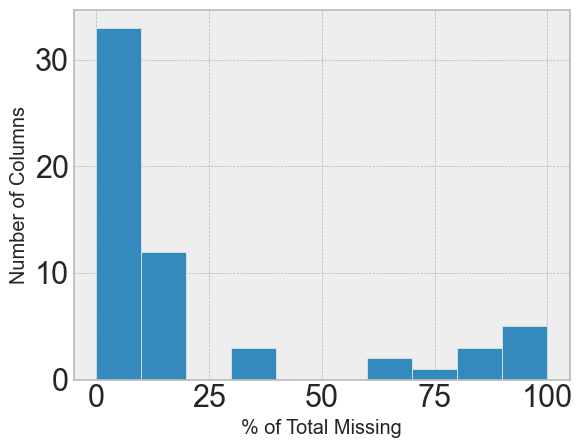

In [10]:
fig = plt.figure()
missing_data_table['% of Total'].hist()
plt.xlabel('% of Total Missing')
plt.ylabel('Number of Columns')

In [11]:
# Filter out columns that have >25% missing data

columns_to_drop = list(missing_data_table[ missing_data_table['% of Total'] > 25 ].index)

data = data.drop(columns=columns_to_drop)
print("Dataframe shape after dropping columns:", data.shape)

Dataframe shape after dropping columns: (11746, 45)


# Exploratory Data Analysis

The next portion of the script will focus on Exploratory Data Analysis (EDA), which refers to the process of making plots and calculations on the data to learn more about its constituent features and data patterns. The purpose of EDA is to find anomalies, trends, or relationships which may be useful when informing modeling decisions downstream. EDA typically begins with a high-level overview and gradually narrows in on more specific features of the dataset. 

We'll start EDA by exploring the Energy Star Score (hereon refered to as just 'score'), which is the target variable for our machine learning model. We'll start with a simple distribution of scores in our dataset.

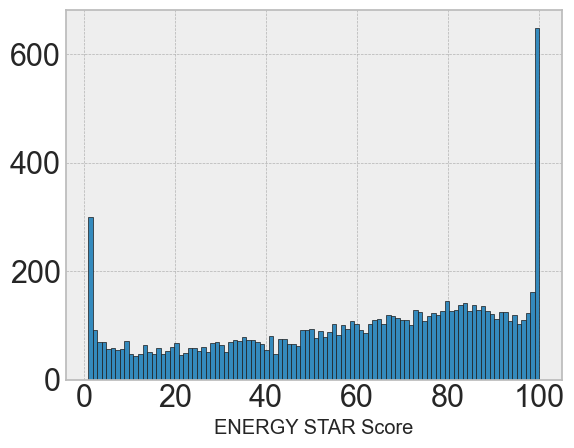

In [12]:
fig = plt.figure()
plt.hist(data['ENERGY STAR Score'].dropna(),bins=100, edgecolor='k')
plt.xlabel("ENERGY STAR Score")
plt.xticks(np.arange(0, 101, 20),np.arange(0, 101, 20));

It's peculiar that there are strong peaks at scores of ~30 and ~60. The distribution is otherwise flat which is to be expected given that energy star scores are equivalent to percentile ranks, according to the official definition (linked [here](https://data.cityofnewyork.us/Environment/NYC-Building-Energy-and-Water-Data-Disclosure-for-/5zyy-y8am/about_data)). The score is based on information provided by applicable property owners to the city. One of these factors is the Site EUI (energy usage intensity), which measures energy usage per square foot. 

In [13]:
print("\nSummary stats:\n", data['Site EUI (kBtu/ft²)'].describe())
print("\nLargest values:\n", data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10))

data.loc[data['Site EUI (kBtu/ft²)']==869265, :]



Summary stats:
 count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

Largest values:
 Property Id
4390425     51328.8
4390422     51831.2
5870209     78360.1
4022813     84969.6
4043349     95560.2
4022808    103562.7
4022803    112173.6
2946993    126307.4
2610789    143974.4
4414323    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64


,Order,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
Property Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4414323,9984,234 Skillman,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3028937502,3028937502,"3390250 , 3338313",234 Skillman avenue,11211,234,SKILLMAN AVENUE,Brooklyn,61811.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,56900.0,2004,1.0,90,Whole Building,1.0,869265.0,939329.0,9.9,9393.0,986366.0,4.945919e+10,5.344589688E8,1983655.6,563239.6,2627199.1,2627015.0,184.1,56900.0,912801.1,05/01/2017 11:34:14 PM,NaN,In Compliance,40.716233,-73.94141,1.0,34.0,477.0,East Williamsburg ...


Upon the first iteration of plotting Site EUI, I produced a histogram that was uninterpretable due to an extreme outlier. To investigate the outlier, I printed the summary stats above and printed the largest values in the 'Site EUI' column. I found one row with the value `869,265.0` while all others were `< 150,000`. Since there was only one outlier in a database with nearly 12,000 rows, I decided to drop this outlier. This was done using the IQR method in the next cell, followed by the final distribution of Site EUI.

In [14]:
# Remove outlier with IQR
first_quartile = data['Site EUI (kBtu/ft²)'].quantile(0.25)
third_quartile = data['Site EUI (kBtu/ft²)'].quantile(0.75)

# IQR (interquartile range)
iqr = third_quartile - first_quartile

# outliers are either below (0.25 - 3IQR) or above (0.75 + 3IQR)
data = data[
    (data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) & 
    (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))
]

Text(0.5, 1.0, 'Site EUI (kBtu/ft²)')

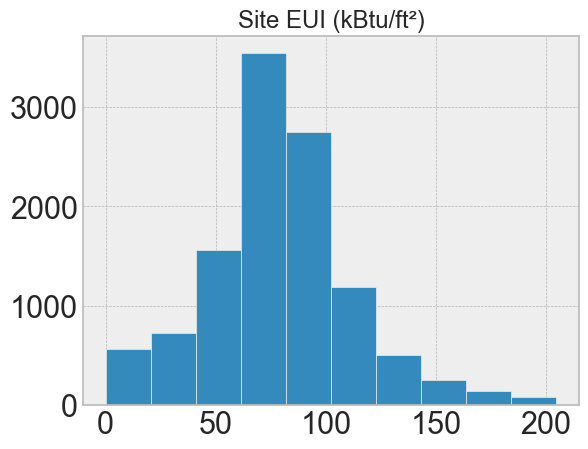

In [15]:
fig = plt.figure()
n_bins = 100
min = data['Site EUI (kBtu/ft²)'].min()
max = data['Site EUI (kBtu/ft²)'].quantile(0.75)
width = (max-min)/n_bins

bins = np.arange(min, max, width)

plt.hist(data['Site EUI (kBtu/ft²)'])
plt.title('Site EUI (kBtu/ft²)')

This distribution appears Gaussian with a positive skew (long tail on the right). The sharp peaks observed in the score distribution do not reappear in this figure.

In [16]:
# explore unique values in the column that indicates property type
column_name = 'Largest Property Use Type'
property_types = list(data[column_name].unique())

print(f"\n\n{column_name}:", data[column_name].unique())
print(f"\nDataset contains {data[column_name].nunique()} unique property types from column `{column_name}`.")



Largest Property Use Type: ['Multifamily Housing' 'College/University' 'Residence Hall/Dormitory'
 'Office' 'Medical Office' 'Library' 'Social/Meeting Hall' 'Other'
 'Self-Storage Facility' 'Strip Mall' 'Retail Store' 'Bank Branch'
 'Movie Theater' 'Hospital (General Medical & Surgical)' 'Enclosed Mall'
 'K-12 School' 'Other - Recreation' 'Financial Office'
 'Manufacturing/Industrial Plant' 'Performing Arts'
 'Other - Lodging/Residential' 'Hotel' 'Non-Refrigerated Warehouse'
 'Parking' 'Other - Entertainment/Public Assembly' 'Restaurant'
 'Senior Care Community' 'Worship Facility' 'Distribution Center'
 'Urgent Care/Clinic/Other Outpatient' 'Other - Mall' 'Other - Education'
 'Museum' 'Automobile Dealership' 'Other - Specialty Hospital'
 'Residential Care Facility' 'Outpatient Rehabilitation/Physical Therapy'
 'Pre-school/Daycare' 'Supermarket/Grocery Store'
 'Mailing Center/Post Office' 'Courthouse' 'Wholesale Club/Supercenter'
 'Other - Services' 'Other - Public Services' 'Refriger

In [17]:
# explore unique values in the column that indicates property type
column_name = 'Primary Property Type - Self Selected'
property_types = list(data[column_name].unique())

print(f"\n\n{column_name}:", data[column_name].unique())
print(f"\nDataset contains {data[column_name].nunique()} unique property types from column `{column_name}`.")



Primary Property Type - Self Selected: ['Multifamily Housing' 'College/University' 'Residence Hall/Dormitory'
 'Office' 'Medical Office' 'Library' 'Social/Meeting Hall' 'Other'
 'Self-Storage Facility' 'Strip Mall' 'Retail Store' 'Bank Branch'
 'Movie Theater' 'Hospital (General Medical & Surgical)' 'Enclosed Mall'
 'K-12 School' 'Other - Recreation' 'Mixed Use Property'
 'Financial Office' 'Manufacturing/Industrial Plant' 'Performing Arts'
 'Other - Lodging/Residential' 'Hotel' 'Data Center'
 'Non-Refrigerated Warehouse' 'Parking' 'Restaurant'
 'Senior Care Community' 'Worship Facility' 'Distribution Center'
 'Urgent Care/Clinic/Other Outpatient'
 'Other - Entertainment/Public Assembly' 'Other - Education'
 'Fitness Center/Health Club/Gym' 'Museum' 'Automobile Dealership'
 'Other - Specialty Hospital' 'Residential Care Facility'
 'Outpatient Rehabilitation/Physical Therapy' 'Other - Mall'
 'Pre-school/Daycare' 'Supermarket/Grocery Store'
 'Mailing Center/Post Office' 'Other - Public

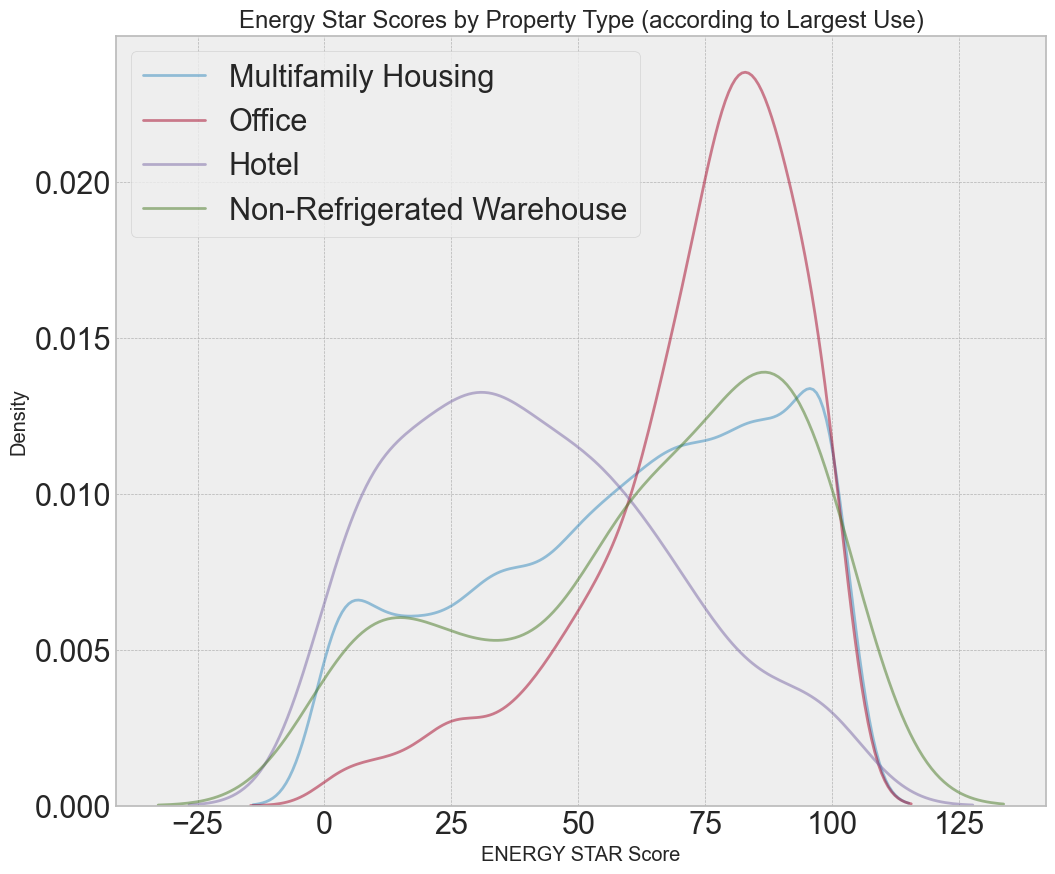

In [18]:
# Plot distribution of Site EUI based on property type in 'largest use' column

# set designated column for determining property type
column_name = 'Largest Property Use Type'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
property_counts = data_with_scores[column_name].value_counts()
property_types = list(property_counts[property_counts.values > 100].index)

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in property_types:
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5
        )
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Largest Use)");

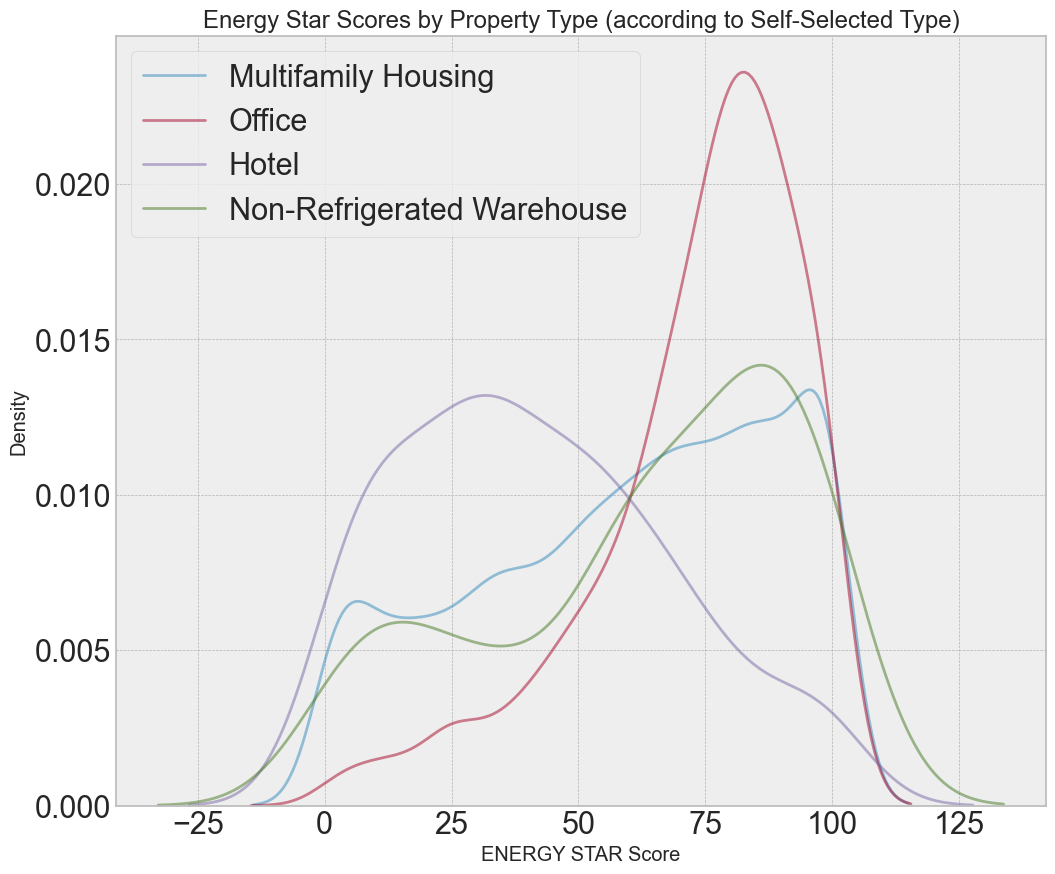

In [19]:
# Plot distribution of Site EUI based on property type in 'largest use' column

# set designated column for determining property type
column_name = 'Primary Property Type - Self Selected'

# drop rows with missing score values
data_with_scores = data.dropna(subset=['ENERGY STAR Score'])
property_counts = data_with_scores[column_name].value_counts()
property_types = list(property_counts[property_counts.values > 100].index)

# initiate new figure
fig = plt.figure(figsize=(12,10))

# iterate through property types
for each_type in property_types[0:5]:
    # filter out relevant rows
    subset = data[data[column_name] == each_type ]
    
    # add to density plot
    sns.kdeplot(
        subset['ENERGY STAR Score'].dropna(),
        label = each_type,
        fill = False,
        alpha = 0.5
        )
plt.legend()
plt.title("Energy Star Scores by Property Type (according to Self-Selected Type)");

The figures above agree well with each other, which is a good sanity check to see that the two categorical columns indicating property type agree well with one another. Since property type does have a role in the star score distribution, we should feed it into the machine learning model (after one-hot encoding). 

In addition to property types, there are other categorical columns such as the borough. We can search for correlations between features using the Pearson correlation coefficient. 

Top 5 Correlations:
 Electricity Use - Grid Purchase (kBtu)              Weather Normalized Site Electricity (kWh)    0.999913
Weather Normalized Source EUI (kBtu/ft²)            Source EUI (kBtu/ft²)                        0.998644
Site EUI (kBtu/ft²)                                 Weather Normalized Site EUI (kBtu/ft²)       0.996782
Largest Property Use Type - Gross Floor Area (ft²)  Property GFA - Self-Reported (ft²)           0.992954
Natural Gas Use (kBtu)                              Direct GHG Emissions (Metric Tons CO2e)      0.966275
dtype: float64
['Electricity Use - Grid Purchase (kBtu)', 'Weather Normalized Site Electricity (kWh)', 'Weather Normalized Source EUI (kBtu/ft²)', 'Source EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)', 'Largest Property Use Type - Gross Floor Area (ft²)', 'Property GFA - Self-Reported (ft²)', 'Natural Gas Use (kBtu)', 'Direct GHG Emissions (Metric Tons CO2e)']


<Axes: >

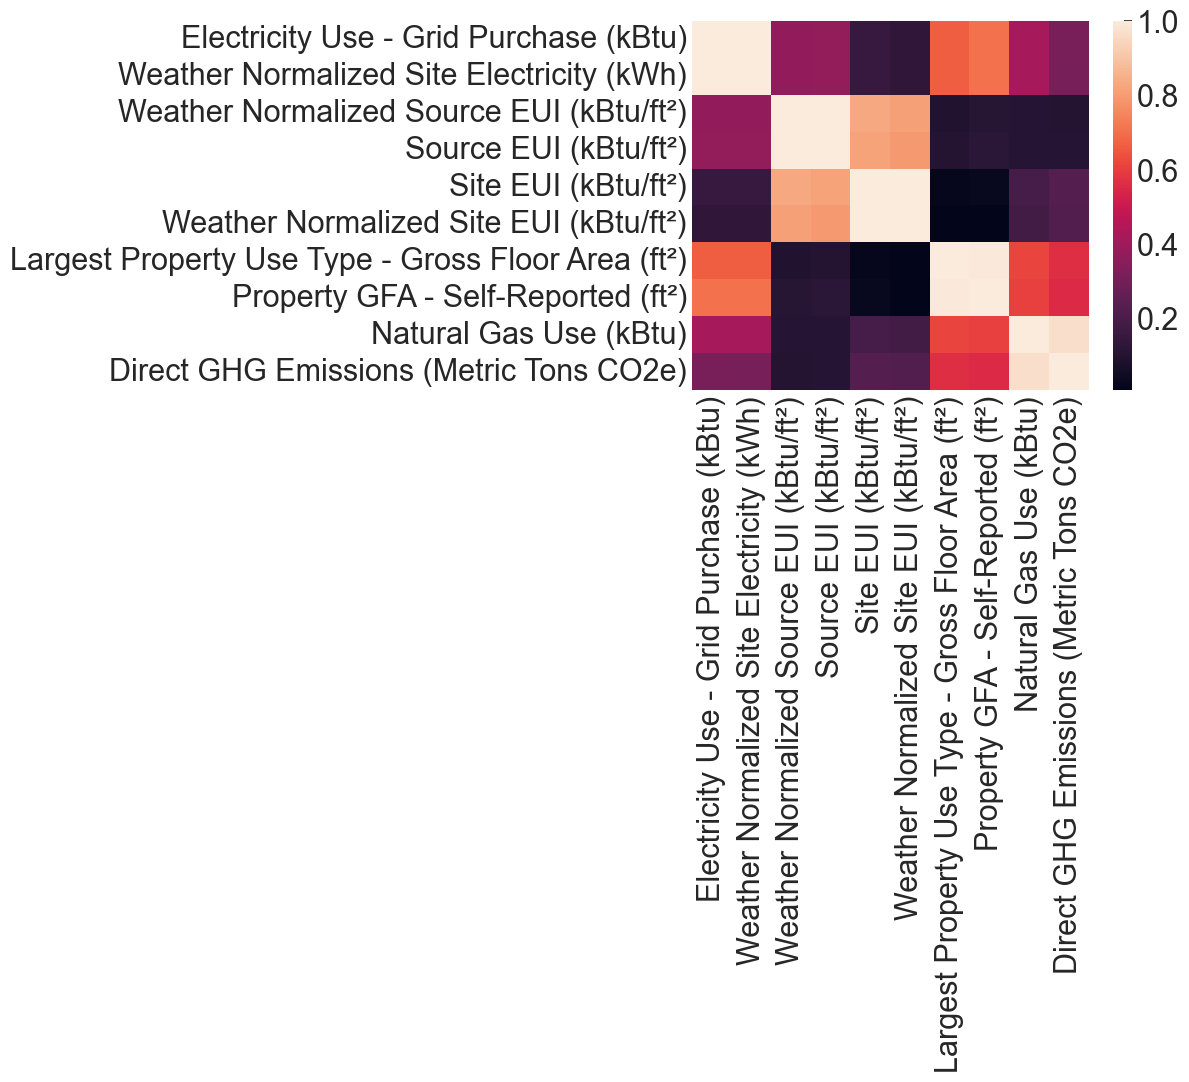

In [39]:
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
correlation_series = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack()



top_5_correlations = correlation_series.nlargest(5)
top_5_features = correlation_series.abs().sort_values(ascending=False).head(5).index.tolist()

columns_to_keep = []
for each_pair in top_5_features:
    if each_pair[0] not in columns_to_keep:
        columns_to_keep.append(each_pair[0])
    if each_pair[1] not in columns_to_keep:
        columns_to_keep.append(each_pair[1])

print("Top 5 Correlations:\n", top_5_correlations)
print((columns_to_keep))
high_corr_data = data[columns_to_keep]
sns.heatmap(high_corr_data.corr())
